In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


# Exploration

In [38]:
airbnb = pd.read_csv("airbnb_train.csv")
airbnb.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,House,Private room,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,Real Bed,flexible,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,House,Private room,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,Real Bed,strict,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,Real Bed,flexible,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,Real Bed,flexible,True,...,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,moderate,True,...,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0


In [27]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22183 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

# Entrainement

In [39]:
class CustomTransformation():
    def __init__(self):
        """
        Classe simple pour convertir les types de propriétés, de chambres, de politiques d'annulation
        et de types de lits en indices numériques, utilisable pour un algorithme de machine learning.
        """
        self.fitted = False  # Indique si fit_transform a été utilisé
        self.property2index = dict()  # Dictionnaire pour convertir les types de propriétés en indices
        self.room2index = dict()  # Dictionnaire pour convertir les types de chambres en indices
        self.cancellation_mapping = {  # Mapping pour cancellation_policy
            "flexible": 4,
            "moderate": 3,
            "strict": 2,
            "super_strict_30": 1,
            "super_strict_60": 0
        }
        self.bed_type_mapping = {  # Mapping pour bed_type
            "Real Bed": 4,
            "Pull-out Sofa": 3,
            "Futon": 2,
            "Airbed": 1,
            "Couch": 0
        }
        self.max_property_index = 0  # Dernier indice pour les types de propriétés
        self.max_room_index = 0  # Dernier indice pour les types de chambres

    def fit_transform(self, dataset):
        self.fitted = True

        # Transformation pour property_type
        properties = dataset["property_type"].unique()
        print("Tous les types de propriétés : ", properties)
        self.property2index = {prop: i for i, prop in enumerate(properties)}
        self.max_property_index = max(self.property2index.values())

        # Transformation pour room_type
        rooms = dataset["room_type"].unique()
        print("Tous les types de chambres : ", rooms)
        self.room2index = {room: i for i, room in enumerate(rooms)}
        self.max_room_index = max(self.room2index.values())

        # Appliquer les transformations
        return self.transform(dataset)

    def transform(self, dataset):
        # Transforme property_type en indices
        dataset.loc[:, "property_type"] = dataset["property_type"].replace(self.property2index)

        # Transforme room_type en indices
        dataset.loc[:, "room_type"] = dataset["room_type"].replace(self.room2index)

        # Transforme cancellation_policy en indices
        dataset.loc[:, "cancellation_policy"] = dataset["cancellation_policy"].replace(self.cancellation_mapping)

        # Transforme bed_type en indices
        dataset.loc[:, "bed_type"] = dataset["bed_type"].replace(self.bed_type_mapping)

        # Gère les valeurs inconnues pour property_type
        dataset.loc[dataset["property_type"].map(type).eq(str), "property_type"] = np.nan
        dataset["property_type"].fillna(self.max_property_index + 1, inplace=True)

        # Gère les valeurs inconnues pour room_type
        dataset.loc[dataset["room_type"].map(type).eq(str), "room_type"] = np.nan
        dataset["room_type"].fillna(self.max_room_index + 1, inplace=True)

        # Gère les valeurs inconnues pour cancellation_policy
        dataset["cancellation_policy"].fillna(-1, inplace=True)  # Remplace les valeurs manquantes par -1

        # Gère les valeurs inconnues pour bed_type
        dataset["bed_type"].fillna(-1, inplace=True)  # Remplace les valeurs manquantes par -1

        # Remplace les valeurs nulles dans d'autres colonnes
        dataset["bathrooms"].fillna(0, inplace=True)
        dataset["accommodates"].fillna(0, inplace=True)

        dataset['host_response_rate'] = (
                dataset['host_response_rate']
                .str.rstrip('%')  # Supprime le symbole '%'
                .astype(float)    # Convertit en float
                .fillna(0)        # Remplace les NaN par 0
                .astype(int)      # Convertit en entier
            )
        
        dataset['instant_bookable'] = dataset['instant_bookable'].replace({'t': 1, 'f': 0})
        dataset['host_has_profile_pic'] = dataset['host_has_profile_pic'].replace({'t': 1, 'f': 0})
        dataset['host_identity_verified'] = dataset['host_identity_verified'].replace({'t': 1, 'f': 0})




        return dataset

In [40]:
features_transformer = CustomTransformation()
airbnb_train = features_transformer.fit_transform(airbnb)
airbnb_train.head(10)

Tous les types de propriétés :  ['House' 'Apartment' 'Townhouse' 'Guest suite' 'Condominium' 'Timeshare'
 'Chalet' 'Guesthouse' 'Bungalow' 'Loft' 'In-law' 'Boat' 'Dorm' 'Other'
 'Bed & Breakfast' 'Camper/RV' 'Villa' 'Boutique hotel' 'Cabin' 'Hostel'
 'Hut' 'Yurt' 'Serviced apartment' 'Castle' 'Vacation home' 'Tent' 'Cave'
 'Tipi' 'Earth House' 'Island' 'Treehouse']
Tous les types de chambres :  ['Private room' 'Entire home/apt' 'Shared room']


C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3782043048.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.loc[:, "property_type"] = dataset["property_type"].replace(self.property2index)
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3782043048.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.loc[:, "room_type"] = dataset["room_type"].replace(self.room2index)
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3782043048.py:53: FutureWarning: Downcasting behavior in `replace` is deprecated and 

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,zipcode,bedrooms,beds
0,5708593,4.317488,0,0,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",3,1.0,4,4,False,...,NaN,33.782712,-118.134410,Island style Spa Studio,Long Beach,0,NaN,90804,0.0,2.0
1,14483613,4.007333,0,0,"{""Wireless Internet"",""Air conditioning"",Kitche...",4,2.0,4,2,False,...,2017-09-17,40.705468,-73.909439,"Beautiful and Simple Room W/2 Beds, 25 Mins to...",Ridgewood,38,86.0,11385,1.0,2.0
2,10412649,7.090077,1,1,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",6,2.0,4,4,False,...,NaN,38.917537,-77.031651,2br/2ba luxury condo perfect for infant / toddler,U Street Corridor,0,NaN,20009,2.0,2.0
3,17954362,3.555348,0,0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1,1.0,4,4,True,...,2017-09-29,40.736001,-73.924248,Manhattan view from Queens. Lovely single room .,Sunnyside,19,96.0,11104,1.0,1.0
4,9969781,5.480639,0,1,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,4,3,True,...,2017-08-28,37.744896,-122.430665,Zen Captured Noe Valley House,Noe Valley,15,96.0,94131,2.0,2.0
5,13113872,6.214608,1,0,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,4,3,True,...,NaN,40.738580,-74.008752,Modern West Village Apartment,West Village,0,NaN,10014,1.0,1.0
6,12032987,4.499810,2,0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,4,2,True,...,2017-09-22,40.806629,-73.949911,Elegant Private Studio - Town House,Harlem,63,98.0,10027,1.0,1.0
7,12112830,4.394449,3,1,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",3,1.0,3,3,False,...,2017-09-25,40.752495,-73.811256,"Private Suite, Free Metrocard*",Flushing,213,93.0,11355,0.0,2.0
8,16738953,4.025352,1,0,"{Internet,""Wireless Internet"",Kitchen,""Pets al...",3,1.0,4,3,True,...,NaN,34.050001,-118.421469,Spacious beautifully lit livingroom,Westside,0,NaN,90064,1.0,1.0
9,94477,5.521461,1,1,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",4,1.0,4,3,True,...,2017-09-16,40.783344,-73.975775,Fabulous UWS 2 Bedroom Apartment!!,Upper West Side,77,96.0,10024,2.0,3.0


In [13]:
airbnb_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22234 entries, 0 to 22233
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      22234 non-null  int64  
 1   log_price               22234 non-null  float64
 2   property_type           22234 non-null  object 
 3   room_type               22234 non-null  object 
 4   amenities               22234 non-null  object 
 5   accommodates            22234 non-null  int64  
 6   bathrooms               22234 non-null  float64
 7   bed_type                22234 non-null  object 
 8   cancellation_policy     22234 non-null  object 
 9   cleaning_fee            22234 non-null  bool   
 10  city                    22234 non-null  object 
 11  description             22234 non-null  object 
 12  first_review            17509 non-null  object 
 13  host_has_profile_pic    22178 non-null  object 
 14  host_identity_verified  22178 non-null

In [6]:
# Identifier les colonnes avec des strings
string_columns = airbnb.select_dtypes(include=['object']).columns
print("Colonnes avec des strings :", string_columns)

# Afficher les valeurs uniques pour chaque colonne de type string
for col in string_columns:
    print(f"\nValeurs uniques dans la colonne '{col}':")
    print(airbnb[col].unique())

Colonnes avec des strings : Index(['property_type', 'room_type', 'amenities', 'bed_type',
       'cancellation_policy', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'name',
       'neighbourhood', 'zipcode'],
      dtype='object')

Valeurs uniques dans la colonne 'property_type':
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Valeurs uniques dans la colonne 'room_type':
[0 1 2]

Valeurs uniques dans la colonne 'amenities':
['{TV,"Wireless Internet",Kitchen,"Free parking on premises","Pets allowed","Suitable for events",Washer,Dryer,"Smoke detector",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron}'
 '{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,"Lock on bedroom door","24-hour check-in","Hair dry

In [41]:
columns_to_exclude = ['amenities', 'city', 'description', 'name', 'neighbourhood', 'zipcode','host_since', 'last_review', 'first_review']
df = airbnb_train.drop(columns=columns_to_exclude)
df.head()

,id,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
0,5708593,4.317488,0,0,3,1.0,4,4,False,1.0,0.0,0,1,33.782712,-118.134410,0,NaN,0.0,2.0
1,14483613,4.007333,0,0,4,2.0,4,2,False,1.0,1.0,100,1,40.705468,-73.909439,38,86.0,1.0,2.0
2,10412649,7.090077,1,1,6,2.0,4,4,False,1.0,0.0,0,1,38.917537,-77.031651,0,NaN,2.0,2.0
3,17954362,3.555348,0,0,1,1.0,4,4,True,1.0,1.0,100,0,40.736001,-73.924248,19,96.0,1.0,1.0
4,9969781,5.480639,0,1,4,1.0,4,3,True,1.0,1.0,100,0,37.744896,-122.430665,15,96.0,2.0,2.0


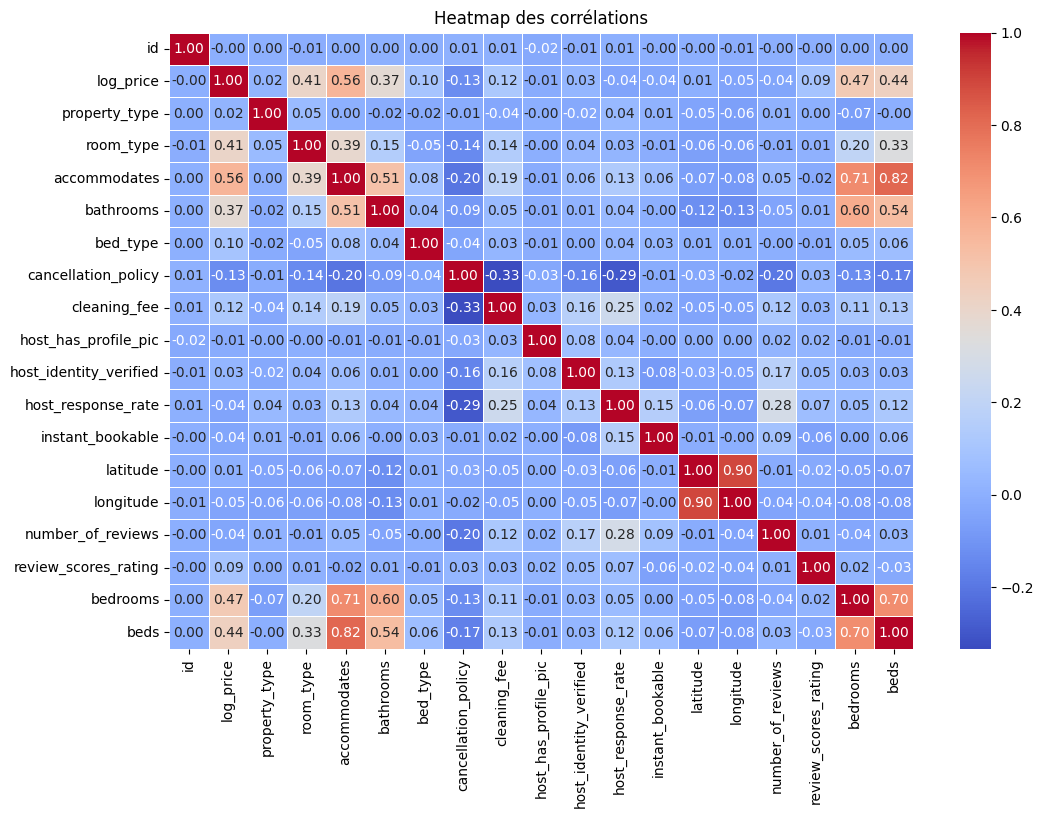

In [42]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()  # Calculer la matrice de corrélation
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap des corrélations')
plt.show()


Colonnes les plus corrélées (y compris les catégorielles encodées) :
log_price                 1.000000
accommodates              0.564874
bedrooms                  0.472871
beds                      0.435212
bathrooms                 0.369118
amenities                 0.126556
cancellation_policy       0.125580
cleaning_fee              0.115116
bed_type                  0.097052
review_scores_rating      0.092342
property_type             0.042389
host_response_rate        0.042209
neighbourhood             0.038004
city                      0.035166
host_identity_verified    0.030548
last_review               0.027050
zipcode                   0.019074
latitude                  0.005231
id                       -0.002122
first_review             -0.006976
host_has_profile_pic     -0.010082
name                     -0.029197
description              -0.030950
number_of_reviews        -0.039138
instant_bookable         -0.040482
longitude                -0.045348
host_since          

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\266821950.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="magma")


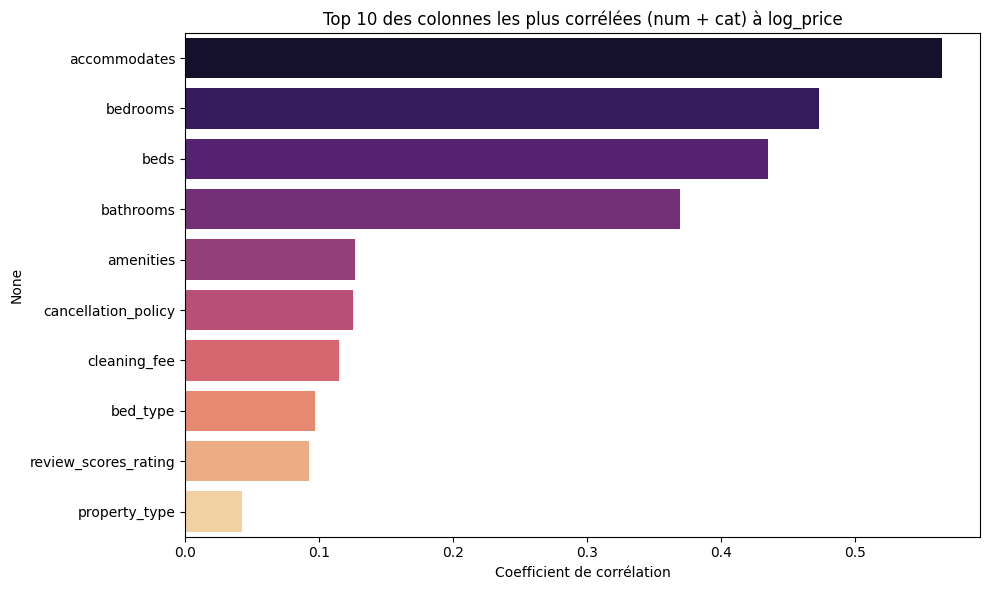

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv("airbnb_train.csv")

# Copie du dataframe
df_encoded = df.copy()

# Liste des colonnes non numériques
cat_cols = df.select_dtypes(include=["object"]).columns

# Encodage des colonnes catégorielles
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    try:
        df_encoded[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    except Exception as e:
        print(f"Erreur sur la colonne {col} : {e}")

# Calcul de la corrélation
correlation_matrix = df_encoded.corr()

# Corrélation avec log_price uniquement
correlations_with_target = correlation_matrix["log_price"].sort_values(ascending=False)

# Affiche les corrélations (numériques + encodées)
print("\nColonnes les plus corrélées (y compris les catégorielles encodées) :")
print(correlations_with_target)

# Affiche un graphique pour les 10 meilleures
plt.figure(figsize=(10, 6))
top_corr = correlations_with_target.drop("log_price").head(10)
sns.barplot(x=top_corr.values, y=top_corr.index, palette="magma")
plt.title("Top 10 des colonnes les plus corrélées (num + cat) à log_price")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()


Colonnes les plus corrélées à log_price :
log_price                 1.000000
accommodates              0.564874
bedrooms                  0.472871
beds                      0.435212
room_type                 0.406694
bathrooms                 0.369118
cleaning_fee              0.115116
city                      0.104990
review_scores_rating      0.092342
instant_bookable          0.040482
host_identity_verified    0.029509
cancellation_policy       0.026986
property_type             0.018080
host_has_profile_pic      0.010082
latitude                  0.005231
host_since                0.004835
host_response_rate        0.004230
description               0.003100
name                      0.002130
amenities                 0.000562
id                       -0.002122
last_review              -0.029980
neighbourhood            -0.032726
first_review             -0.033005
number_of_reviews        -0.039138
longitude                -0.045348
bed_type                 -0.097958
zipcode     

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\2014196081.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


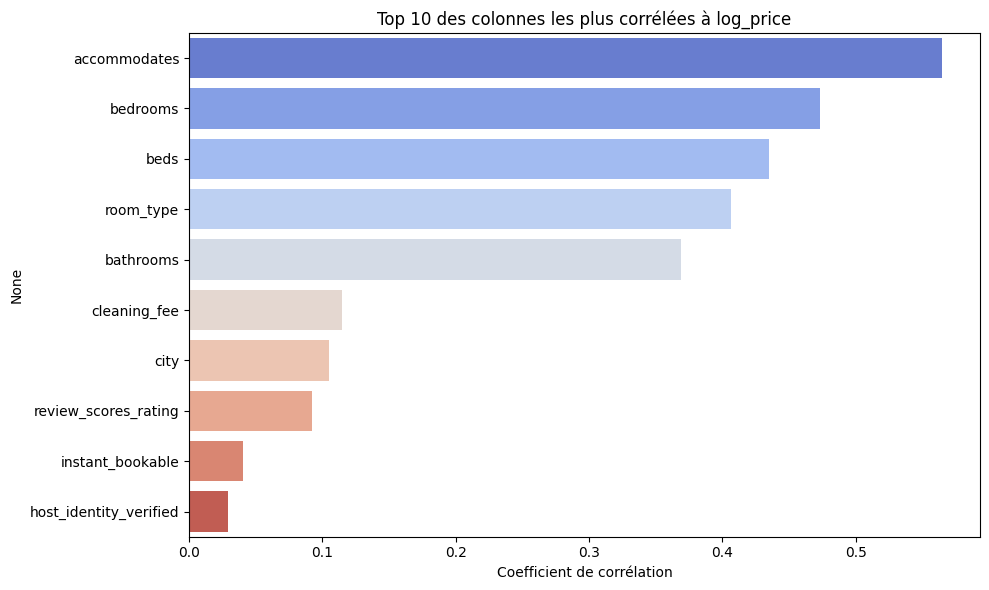

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv("airbnb_train.csv")

# Encodage des colonnes catégoriques
df_encoded = df.copy()
cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    df_encoded[col] = df_encoded[col].astype(str).factorize()[0]

# Calcul de la matrice de corrélation
correlation_matrix = df_encoded.corr()

# Corrélation avec log_price uniquement
correlations_with_target = correlation_matrix["log_price"].sort_values(ascending=False)

# Afficher les colonnes les plus corrélées
print("\nColonnes les plus corrélées à log_price :")
print(correlations_with_target)

# Visualiser les 10 colonnes les plus corrélées
plt.figure(figsize=(10, 6))
top_corr = correlations_with_target.drop("log_price").head(10)
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Top 10 des colonnes les plus corrélées à log_price")
plt.xlabel("Coefficient de corrélation")
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score

# Étape 1 : Charger les données
airbnb = pd.read_csv("airbnb_train.csv")

# Étape 2 : Transformation personnalisée
class CustomTransformation:
    def __init__(self):
        self.fitted = False
        self.property2index = {}
        self.max_index = 0

    def fit_transform(self, dataset):
        self.fitted = True
        properties = dataset["property_type"].unique()
        self.property2index = {prop: i for i, prop in enumerate(properties)}
        self.max_index = max(self.property2index.values())
        return self.transform(dataset)

    def transform(self, dataset):
        dataset.loc[:, "property_type"] = dataset["property_type"].replace(self.property2index)
        dataset.loc[dataset["property_type"].map(type).eq(str), "property_type"] = np.nan
        dataset["property_type"].fillna(self.max_index + 1, inplace=True)
        dataset["bathrooms"].fillna(0, inplace=True)
        dataset["accommodates"].fillna(0, inplace=True)
        return dataset

# Étape 3 : Sélection des colonnes utiles
class FeatureSelection:
    def transform(self, dataset):
        return dataset[["property_type", "accommodates", "bathrooms"]].copy()

# Initialiser les transformations
features_transformer = CustomTransformation()
feature_selector = FeatureSelection()

# Appliquer les transformations
airbnb_train = features_transformer.fit_transform(airbnb)
airbnb_train = feature_selector.transform(airbnb_train)

# Étape 4 : Préparer les données pour l'entraînement
X = airbnb_train
y = airbnb["log_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 5 : Entraîner le modèle
model = LinearSVR(random_state=42)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f"Score en entraînement : {r2_score(y_train, y_pred_train):.4f}")
print(f"Score en test : {r2_score(y_test, y_pred_test):.4f}")

# Étape 6 : Charger les données de test
airbnb_test = pd.read_csv("airbnb_test.csv")
final_X_test = features_transformer.transform(airbnb_test)
final_X_test = feature_selector.transform(final_X_test)

# Prédictions finales
y_final_prediction = model.predict(final_X_test)

# Étape 7 : Sauvegarder les prédictions dans un fichier CSV
prediction_example = pd.read_csv("prediction_example.csv")
prediction_example["logpred"] = y_final_prediction
prediction_example.to_csv("MaPredictionFinale.csv", index=False)

print("Les prédictions ont été sauvegardées dans 'MaPredictionFinale.csv'.")

C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3006653764.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.loc[:, "property_type"] = dataset["property_type"].replace(self.property2index)
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3006653764.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the

Score en entraînement : 0.3247
Score en test : 0.3175
Les prédictions ont été sauvegardées dans 'MaPredictionFinale.csv'.


C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3006653764.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset["property_type"].fillna(self.max_index + 1, inplace=True)
C:\Users\Aurélien\AppData\Local\Temp\ipykernel_25516\3006653764.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["pro

In [51]:
def estConforme(monFichier_csv):
    votre_prediction = pd.read_csv(monFichier_csv)

    fichier_exemple = pd.read_csv("prediction_example.csv")

    assert votre_prediction.columns[1] == fichier_exemple.columns[1], f"Attention, votre colonne de prédiction doit s'appeler {fichier_exemple.columns[1]}, elle s'appelle '{votre_prediction.columns[1]}'"
    assert len(votre_prediction) == len(fichier_exemple), f"Attention, vous devriez avoir {len(fichier_exemple)} prédiction dans votre fichier, il en contient '{len(votre_prediction)}'"

    assert np.all(votre_prediction.iloc[:,0] == fichier_exemple.iloc[:, 0])

    print("Fichier conforme!")

estConforme("MaPredictionFinale.csv")

Fichier conforme!


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Charger les vraies valeurs de log_price
y_true = airbnb["log_price"]  # Les vraies valeurs de log_price dans airbnb_train

# Charger vos prédictions
predictions = pd.read_csv("MaPredictionFinale.csv")
y_pred = predictions["logpred"]

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE (Mean Absolute Error) : {mae:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"R² (Coefficient de détermination) : {r2:.4f}")

ValueError: Found input variables with inconsistent numbers of samples: [22234, 51877]

In [54]:
print(f"Taille de airbnb_train : {len(airbnb)}")
print(f"Taille de MaPredictionFinale.csv : {len(predictions)}")

Taille de airbnb_train : 22234
Taille de MaPredictionFinale.csv : 51877


In [55]:
# Prédictions sur l'ensemble d'entraînement
y_pred_train = model.predict(X_train)

# Calcul des métriques sur l'ensemble d'entraînement
mae = mean_absolute_error(y_train, y_pred_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2 = r2_score(y_train, y_pred_train)

print(f"MAE (Mean Absolute Error) : {mae:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"R² (Coefficient de détermination) : {r2:.4f}")

MAE (Mean Absolute Error) : 0.4489
RMSE (Root Mean Squared Error) : 0.5912
R² (Coefficient de détermination) : 0.3247
